In [1]:
# Project: p6
# Submitter: hhess3
# Partner: None
# Hours: 10

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np 
import rasterio
import matplotlib.pyplot as plt
from rasterio.mask import mask
import zipfile
import io
import os
from sklearn.metrics import explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#Q1
counties_gdf = gpd.read_file('counties.geojson')
len(counties_gdf)


72

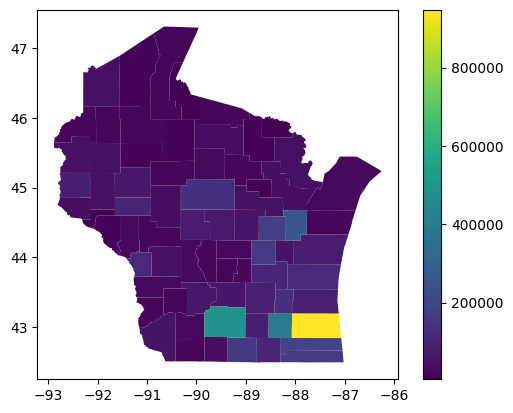

In [3]:
#Q2
counties_gdf.plot(column='POP100', legend=True)
plt.show()

In [4]:
#Q3
conn = sqlite3.connect('counties_tracts.db')
arealand_df = pd.read_sql("""SELECT NAME, AREALAND FROM counties;""", conn)
counties_gdf["AREALAND"] = arealand_df["AREALAND"]

X_data = counties_gdf[["AREALAND"]]
y_data = counties_gdf["POP100"]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.25, random_state=250)

test_indices = X_test.index
county_name_list = counties_gdf.loc[test_indices, "NAME"].to_list()
county_name_list

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [5]:
#Q4
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

r2

0.016720430179409274

In [6]:
#Q5
converter = 2.59
area_in_sqr_miles = 400
area_in_sqr_km = converter * area_in_sqr_miles
area_in_sqr_meters = area_in_sqr_km * 1000000

pred_area = pd.DataFrame([[area_in_sqr_meters]])
pred_pop = model.predict(pred_area)
pred_pop[0]

/home/hhess3/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


90000.07422783462

In [7]:
#Q6
conn = sqlite3.connect('counties_tracts.db')
housing_query = """SELECT c.NAME, SUM(t.HU100) as total_HU100 FROM tracts t JOIN counties c on t.COUNTY = c.COUNTY GROUP BY 
c.NAME;"""

housing_data = pd.read_sql(housing_query, conn)
new_gdf = counties_gdf.merge(housing_data, on = 'NAME', how = 'left')
hu_train_set, hu_test_set = train_test_split(new_gdf, test_size = 0.25, random_state=250)

test_county_names_list = []
df = pd.DataFrame(hu_test_set)
county_name = pd.Series(df['NAME'])
test_county_names_list = county_name.tolist()
test_county_names_list 

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [8]:
#Q7
test_hu100_dict = {}

for county_name in test_county_names_list:
    hu_value = hu_test_set.loc[hu_test_set['NAME'] == county_name, 'total_HU100'].values
    if len(hu_value) > 0:
        test_hu100_dict[county_name] = hu_value[0]

test_hu100_dict

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [9]:
#Q8
hu_feature = 'total_HU100'

linear_reg = LinearRegression()

if hu_feature in hu_train_set.columns:
    cv_scores = cross_val_score(linear_reg, hu_train_set[[hu_feature]], y_train, cv=5, scoring='r2')

    average_variance_explained = cv_scores.mean()

average_variance_explained

0.9739348181232653

In [10]:
#Q9
mean_cv_score = cv_scores.mean()

squared_diff = [(score - mean_cv_score) ** 2 for score in cv_scores]

variance = sum(squared_diff) / len(cv_scores)

std_dev = variance ** 0.5

std_dev

0.01693954236334351

In [11]:
#Q10
hu_feature = 'total_HU100'

linear_reg = LinearRegression()

if hu_feature in hu_train_set.columns:
    linear_reg.fit(hu_train_set[[hu_feature]], y_train)

    coefficient = linear_reg.coef_[0]
    intercept = linear_reg.intercept_

    formula = f"POP100 = {coefficient:.2f}*HU100 + {intercept:.2f}"
    
formula

'POP100 = 2.47*HU100 + -9276.89'

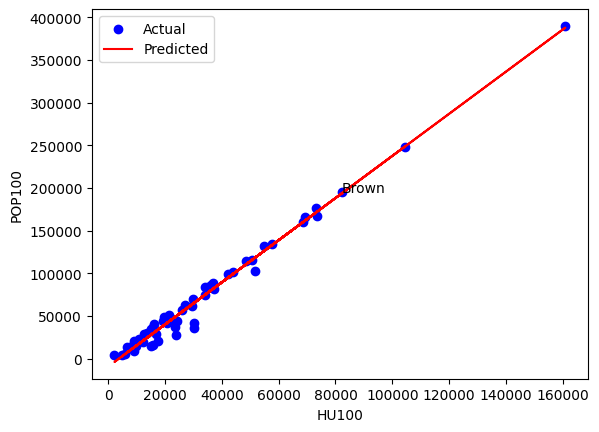

In [12]:
#Q11
hu_X_train = hu_train_set[['total_HU100']]
hu_y_train = hu_train_set['POP100']

model = LinearRegression()
model.fit(hu_X_train, hu_y_train)

hu_y_pred = model.predict(hu_X_train)

plt.scatter(hu_X_train[['total_HU100']], hu_y_train, color='blue', label='Actual') 
plt.plot(hu_X_train[['total_HU100']], hu_y_pred, color='red', label='Predicted')

plt.text(hu_X_train.loc[0, 'total_HU100'], hu_y_train[0], 'Brown')

plt.legend()
plt.xlabel('HU100')
plt.ylabel('POP100')
plt.show()

In [13]:
#Q12 
A = np.array([
    [0, 0, 5, 8, 4],
    [1, 2, 4, 0, 3],
    [2, 4, 0, 9, 2],
    [3, 5, 2, 1, 1],
    [0, 5, 0, 1, 0]
])

count_between_3_and_6 = np.sum((A >= 3) & (A <= 6))
count_between_3_and_6

8

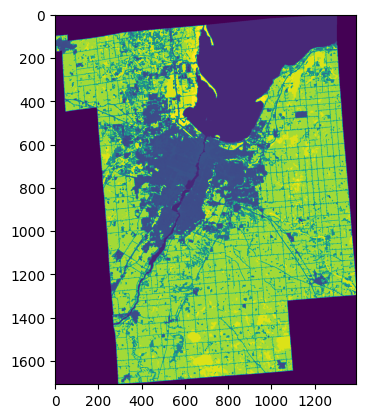

In [14]:
#Q13
land = rasterio.open("zip://../p6/land.zip!wi.tif")

counties_gdf = gpd.read_file('counties.geojson')
brown_county = counties_gdf[counties_gdf["NAME"]== "Brown County"]

matrix, _ = mask(land, brown_county.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]
plt.imshow(matrix)

In [15]:
#Q14
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

total_non_zero_cells = np.count_nonzero(matrix)

open_water_count = np.count_nonzero(matrix == land_use["open_water"])

portion_open_water = open_water_count / total_non_zero_cells 

portion_open_water

0.13797526789725206

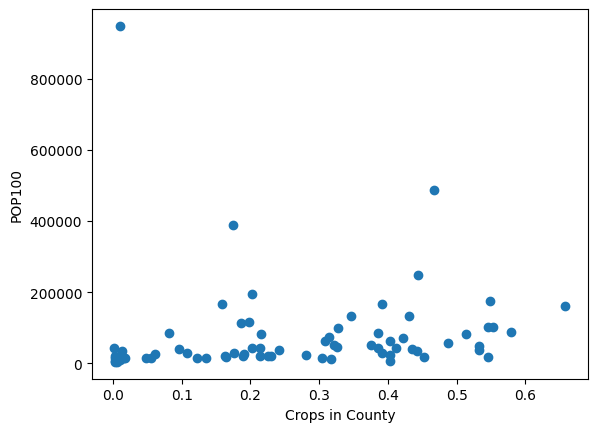

In [16]:
#Q15 
crops_list = []
pop_list = []
row = 0

for i in counties_gdf.NAME:
    new_df = counties_gdf[counties_gdf.NAME==i]
    matrix, _ = mask(land, new_df.to_crs(land.crs)["geometry"], crop = True)
    matrix = matrix[0]
    pop_list.append(new_df['POP100'][row])
    crops_data = land_use['crops']
    crops = (np.sum(matrix == crops_data))/(np.sum(matrix!=0))
    crops_list.append(crops)
    row += 1 

plt.scatter(crops_list, pop_list)
plt.xlabel("Crops in County")
plt.ylabel("POP100")
plt.show()                        

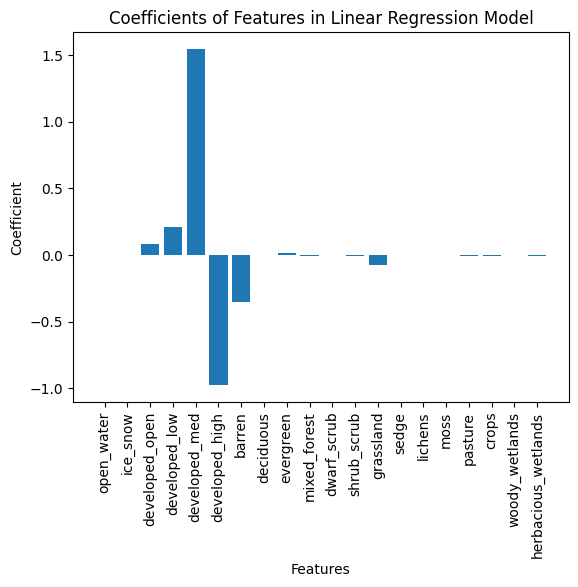

In [17]:
#Q16
tracts_gdf = gpd.read_file('tracts.shp')
land = rasterio.open("zip://../p6/land.zip!wi.tif")

for idx in tracts_gdf.index:
    tract = tracts_gdf[tracts_gdf.index == idx]
    matrix, _ = mask(land, tract.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    for key in land_use:
        num_uses = sum(sum(matrix == land_use[key]))
        tracts_gdf.at[idx, key] = num_uses
        
xcols = list(land_use.keys())    
features = tracts_gdf[xcols]
target = tracts_gdf['POP100']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=300)

model = LinearRegression()
model.fit(X_train[xcols], y_train)

coefficients = model.coef_

plt.bar(xcols, coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficients of Features in Linear Regression Model')
plt.xticks(rotation=90)
plt.show()        

# The graph displays the coefficients of each feature in the trained regression model.
# Higher coefficient values indicate stronger influences of those features on predicting POP100.
# By analyzing these coefficients, we can identify which features have the most impact on the target variable

In [18]:
# Part 2
# 1st Regression Model
features = ['developed_med', 'developed_high']
target = 'POP100'

tract_train, tract_test = train_test_split(tracts_gdf, test_size=0.20, random_state=300)

X_train = tract_train[features]
y_train = tract_train[target]

X_test = tract_test[features]
y_test = tract_test[target]

model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)

first_cv_scores = cross_val_score(model, X_train, y_train, cv=5)
first_evs = explained_variance_score(y_test, predict)
first_evs

0.39432236647671326

In [19]:
#Q17
# Model 2
features = ['developed_med', 'developed_high', 'barren', 'developed_low']
target = ['POP100']

tract_train, tract_test = train_test_split(tracts_gdf, test_size=0.20, random_state=300)

X_train2 = tract_train[features]
y_train2 = tract_train[target]

X_test2 = tract_test[features]
y_test2 = tract_test[target]

pipe = Pipeline([('transformer', PolynomialFeatures(degree=2)), ('model', LinearRegression())])

pipe.fit(X_train2, y_train2)
predict = pipe.predict(X_test2)

cv_scores2 = cross_val_score(pipe, X_train2, y_train2, cv=5)
variance2 = explained_variance_score(y_test2, predict)
variance2

# Given that Model 2 outperforms Model 1 in both mean CV score and explained variance on the test set, while also 
# having similar variance in cross-validation scores, Model 2 seems to perform slightly better for predicting 'POP100'.
# Therefore, based on these metrics, Model 2, utilizing Polynomial Regression with 'developed_low', 'barren', and 'water' 
# features, would be recommended for this prediction task of 'POP100' in my opinion. While it might not be as simple as Model 1,
# it gets the job done better and more efficiently

0.47401318409943594